This is a brief and simple data analysis of the housing market of the north of Madrid (Spain) during Fall/Winter 2016. The data was daily collected by a Golang self-made scraper and dumped into a PostgreSQL database.

Let's start by importing the needed libraries.

In [297]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sc
import seaborn as sns
plt.rc('figure', figsize=(12, 5))

Pandas will be used to read the CSV dump of the database table storing all the flat information.

In [319]:
df = pd.read_csv("flats.csv", parse_dates= ["date_published"])
df = df[df.price<5000]
df.head()

,id,name,price,rooms,size,store,elevator,link,area,date_published
0,34621299,"Ático en calle blanca de navarra, 3, Almagro, ...",2200,2,45,5,t,/inmueble/34621299/,chamberi,2016-09-24
1,34615419,"Piso en Almagro, Madrid 912 663 857",1000,1,50,7,t,/inmueble/34615419/,chamberi,2016-09-24
2,34615289,"Piso en calle covarrubias, Trafalgar, Madrid 9...",2000,3,106,3,t,/inmueble/34615289/,chamberi,2016-09-24
3,34613105,"Piso en calle general álvarez de castro, 27, T...",1200,2,85,5,t,/inmueble/34613105/,chamberi,2016-09-24
4,34612492,"Piso en calle del monte esquinza, s/n, Almagro...",1300,2,110,1,t,/inmueble/34612492/,chamberi,2016-09-24


Seems like all the data is more or less nice and clean since we were deciding on how to format it when dumping it into
postgres.

Let's perform some basic feature counts in order to make some sense of the collected data.

In [14]:
df["rooms"].value_counts()

1    1116
2     774
3     288
0     256
4     103
5      15
6      14
7       2
8       1
Name: rooms, dtype: int64

In [20]:
df["store"].value_counts()[:10]

1     474
2     465
3     392
0     292
4     278
5     238
6     150
7     119
8      44
10     37
Name: store, dtype: int64

In [15]:
df["area"].value_counts()

chamberi     986
tetuan       928
chamartin    655
Name: area, dtype: int64

In [21]:
df["elevator"].value_counts()

t    1983
f     586
Name: elevator, dtype: int64

It looks like most of the flats that were posted belonged to Chamberi or Tetuan neighborhood, had 1 or 2 rooms, in lower stores and with elevator.

Now, let's group by area to see how the place of the flat affected the rest of the features.

## Flats by area

In [33]:
mean_prices = df.groupby("area").mean()
mean_prices

,id,price,rooms,size,store
area,,,,,
chamartin,3.272507e+07,1100.059542,1.621374,75.604580,3.709924
chamberi,3.327247e+07,1231.416836,1.660243,70.515213,2.919878
tetuan,3.262621e+07,962.015086,1.532328,66.338362,3.351293


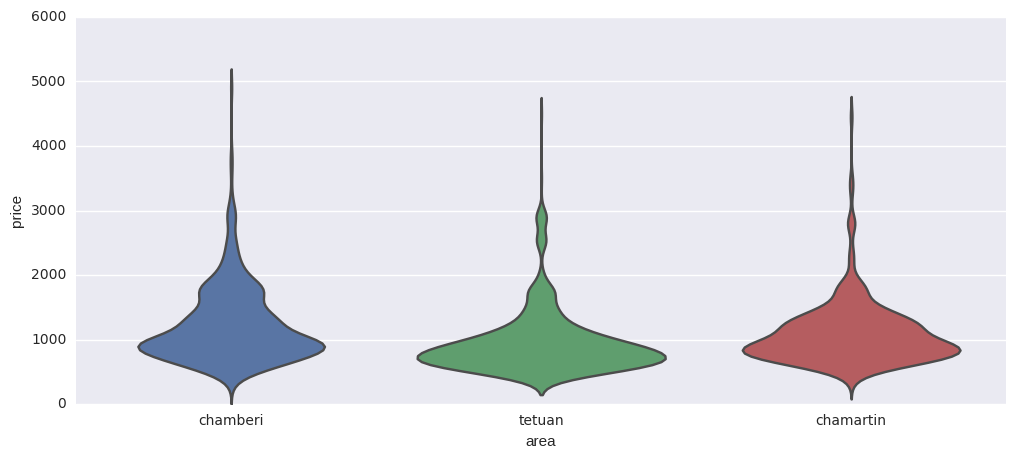

In [334]:
sns.violinplot(x="area", y="price", data=df, inner=None)

## Time Series Analysis

In order to analyze flats over time, it is more suitable to have the data as a time series so that it can be manipulated naturally and easily.

In [206]:
dates = pd.date_range(df.date_published.min(), df.date_published.max(), freq='D')
df_group = df.groupby("date_published").mean()

### Flat prices over time

First of all, let's check how the flat prices vary over time. For that, we can plot the moving average with a window of 12 days.

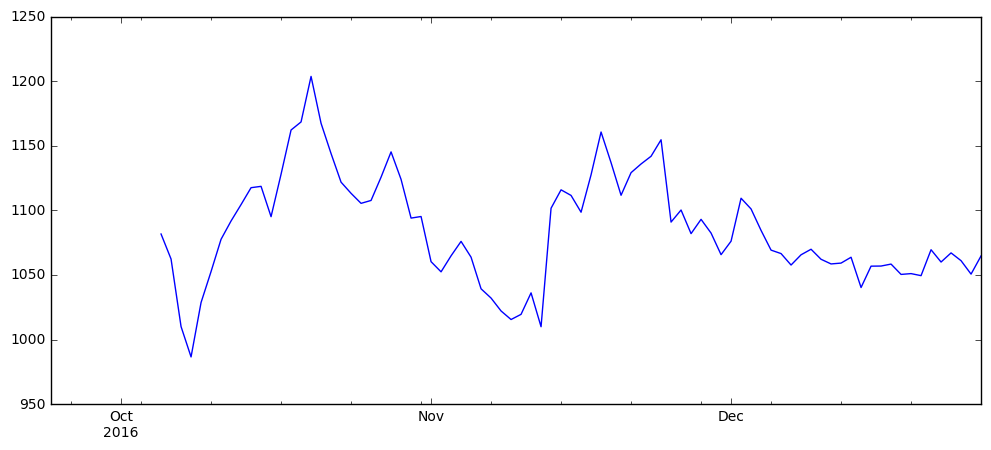

In [207]:
df_price_series = pd.Series(df_group["price"], index=dates)
df_price_series.rolling(center=False, window=12).mean().plot()

Since this is more of a visual technique, it is not very clear from looking at it if there is some stationarity in the prices of the flats. We can use the same statistical plot along with a statistical test such as Dickey-Fuller.

The Dickey-Fuller test is a stationarity test where the null hypothesis is that the time series is non-stationary. The results of the test consist of a *test statistic* and some *critical values* for different confidence levels. If the *test statistic* is less than the *critical values*, we can reject the null hypothesis and, therefore, say that the time series is stationary.

Let's define a function computes this statistical plots (original TS, rolling mean and rolling std) and uses the *statsmodel* package to compute the Dickey-Fuller test results.

In [208]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(center=False, window=12).mean()
    rolstd = timeseries.rolling(center=False, window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

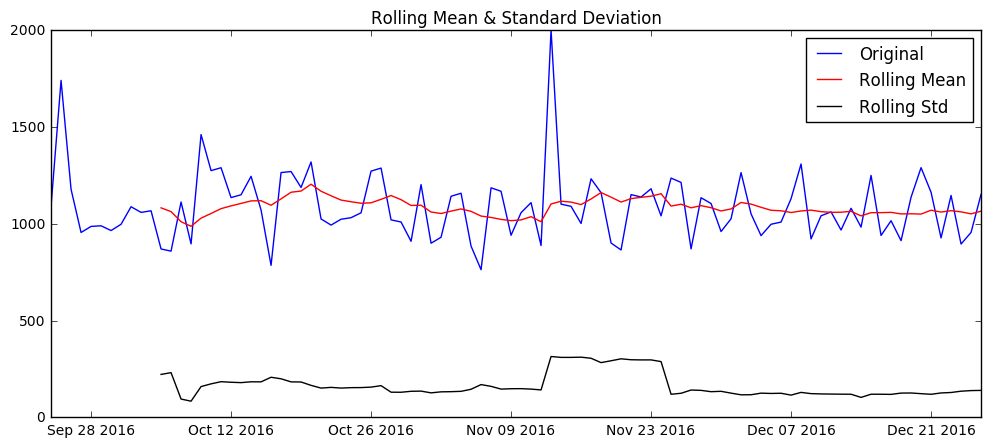

Results of Dickey-Fuller Test:
Test Statistic                -9.345013e+00
p-value                        8.593012e-16
#Lags Used                     0.000000e+00
Number of Observations Used    9.300000e+01
Critical Value (5%)           -2.893158e+00
Critical Value (1%)           -3.502705e+00
Critical Value (10%)          -2.583637e+00
dtype: float64


In [209]:
test_stationarity(df_price_series)

Since the *Test Statistic* result from the Dickey-Fuller test is lower than the *Critical Values*, we can say that the time series of flat prices is stationary.

### Flat sizes over time

Now let's do the same with flat sizes time series.

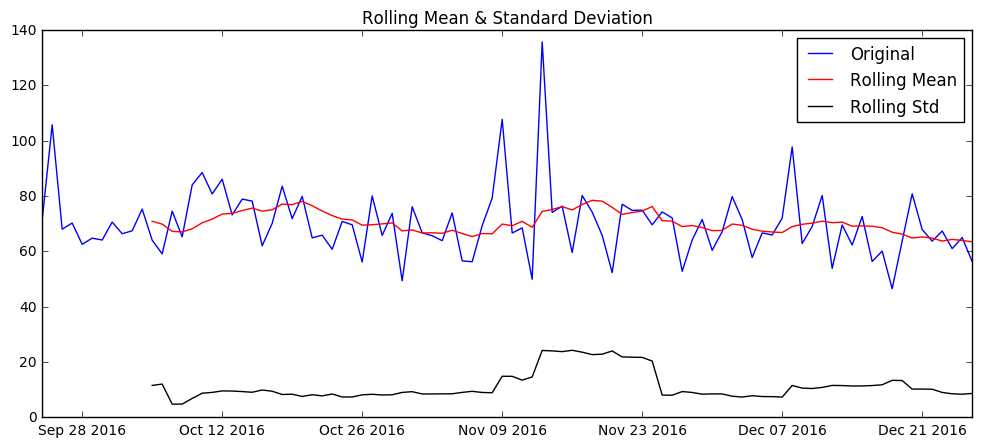

Results of Dickey-Fuller Test:
Test Statistic                 -3.983617
p-value                         0.001499
#Lags Used                      3.000000
Number of Observations Used    90.000000
Critical Value (5%)            -2.894232
Critical Value (1%)            -3.505190
Critical Value (10%)           -2.584210
dtype: float64


In [210]:
df_size_series = pd.Series(df_group["size"], index=dates)
test_stationarity(df_size_series)

Flat prices is also a stationary time series since the *Test Statistic* is lower than the *Critical Values*.

### Number of Flats over time

Finally, let's try the same with the number of flats posted over time.

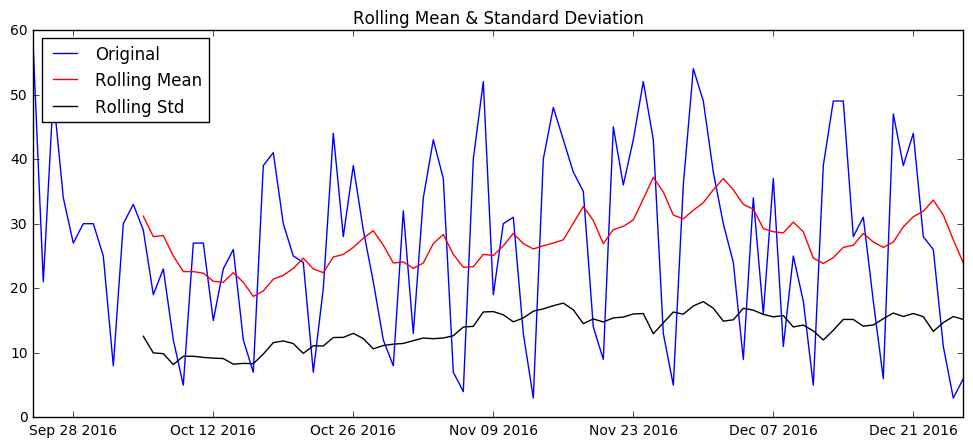

Results of Dickey-Fuller Test:
Test Statistic                 -2.291731
p-value                         0.174649
#Lags Used                      6.000000
Number of Observations Used    87.000000
Critical Value (5%)            -2.895382
Critical Value (1%)            -3.507853
Critical Value (10%)           -2.584824
dtype: float64


In [218]:
df_num_series = pd.Series(df.groupby("date_published").size(), index=dates)
test_stationarity(df_num_series)

In this case, the number of flats posted is not a stationary time series since the *Test Statistic* is higher than the *Critical Values*.

There are a different number of techniques to make a times series stationary. One such is **transformation**, in which higher values get penalized more than lower values. Lets take a log transform over our number of flats time series.

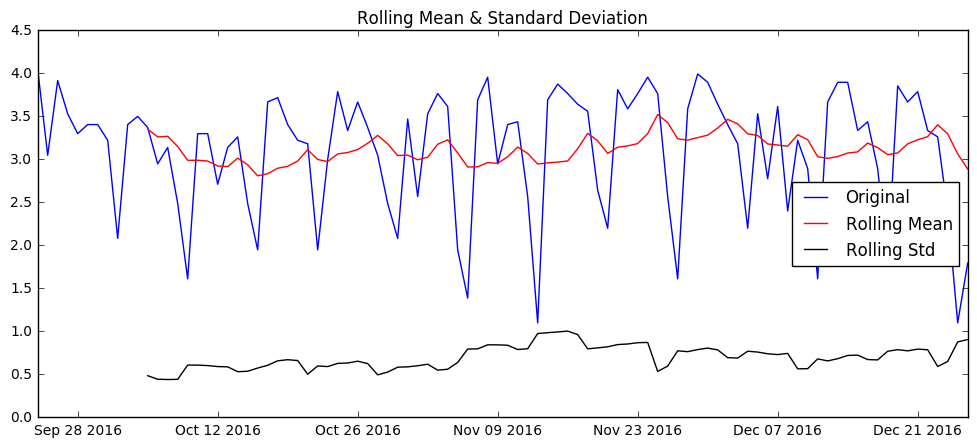

Results of Dickey-Fuller Test:
Test Statistic                 -2.868251
p-value                         0.049166
#Lags Used                     10.000000
Number of Observations Used    83.000000
Critical Value (5%)            -2.897048
Critical Value (1%)            -3.511712
Critical Value (10%)           -2.585713
dtype: float64


In [222]:
ts_log = np.log(df_num_series)
test_stationarity(ts_log)

Now, we can say that the new time series is stationary with 90% of confidence. 

Another technique that might yield better results is called **smoothing**. Smoothing refers to taking rolling estimates and substracting it to the original values in order to remove trends.

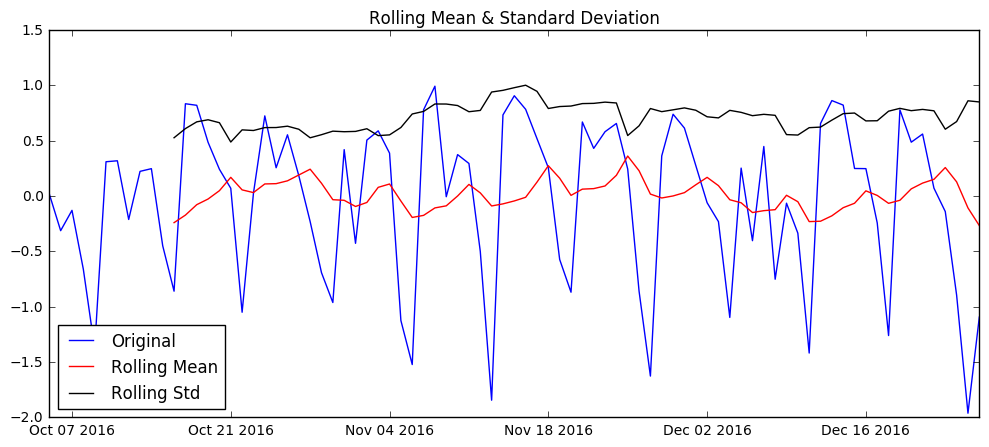

Results of Dickey-Fuller Test:
Test Statistic                 -3.558180
p-value                         0.006613
#Lags Used                     10.000000
Number of Observations Used    72.000000
Critical Value (5%)            -2.902607
Critical Value (1%)            -3.524624
Critical Value (10%)           -2.588679
dtype: float64


In [226]:
moving_avg = ts_log.rolling(center=False, window=12).mean()
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

Now the time series is stationary with 99% confidence.

### Forecasting Flat Prices

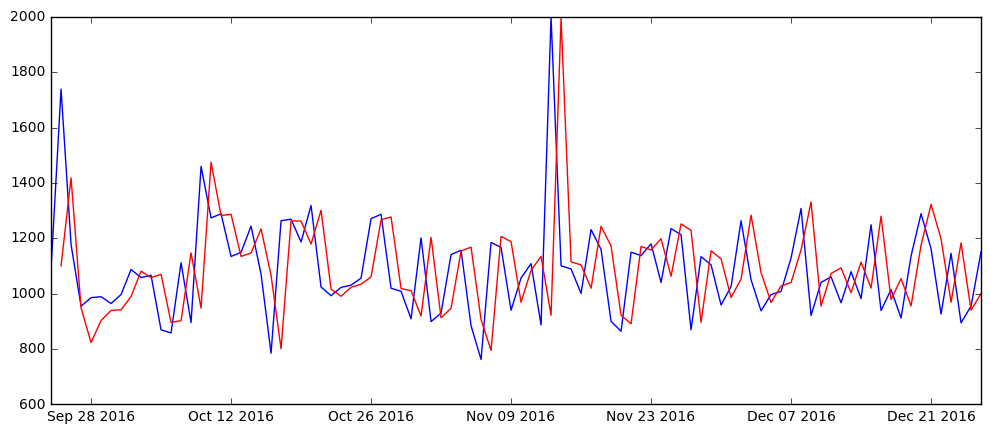

In [283]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_price_series, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(df_price_series)
plt.plot(-results_ARIMA.fittedvalues+1100, color='red')

## Top 10 most expensive flats

In [52]:
df_top10 = df.sort_values(by="price", ascending = False)[:10]

In [53]:
df_top10.groupby("area").size()

area
chamartin    3
chamberi     5
tetuan       2
dtype: int64

## Correlations analysis

In order to see how the features are correlated to each other, let's compute the correlation matrix.

In [300]:
del df["id"]
cm = df.corr()
cm

,price,rooms,size,store
price,1.000000,0.540666,0.667652,0.166836
rooms,0.540666,1.000000,0.548523,0.034503
size,0.667652,0.548523,1.000000,0.138522
store,0.166836,0.034503,0.138522,1.000000


As expected, the price of a flat is strongly correlated with its size and the number of rooms. Also, although less interesting, there is a correlation between the size of the flat and the number of rooms.

We can represent the same information more visually with a heatmap.

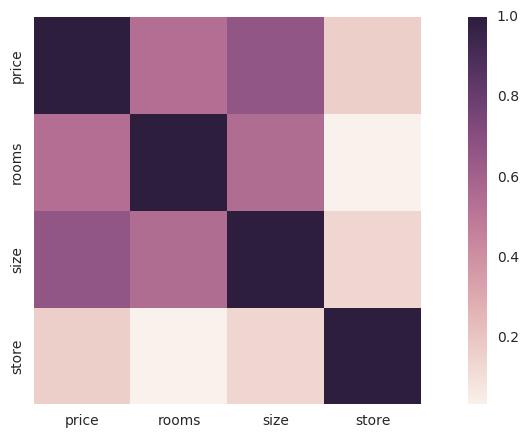

In [303]:
sns.heatmap(cm,square=True)

Now we'll make a scatter plot with the size of the flat and its price.

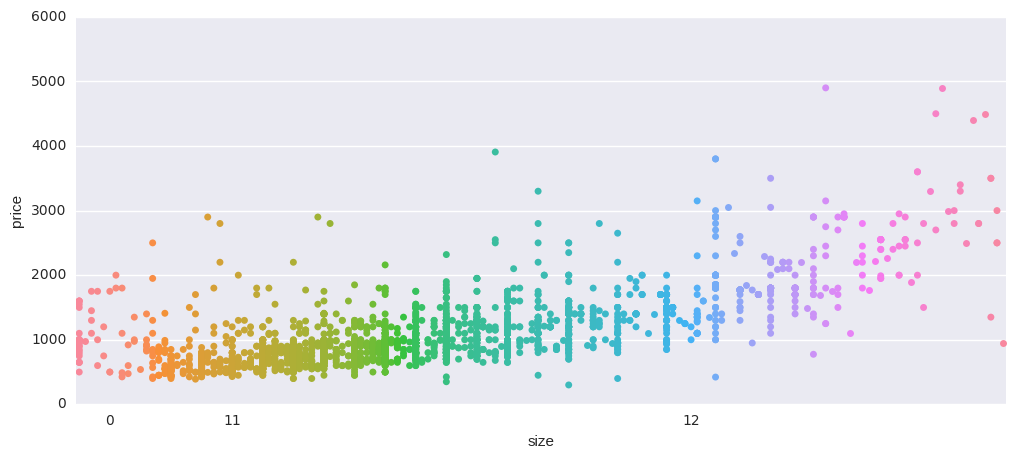

In [351]:
sns.stripplot(x=df["size"], y=df["price"])